### Imports

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

### Initialize the LLM

In [2]:
load_dotenv()

groq_key = os.getenv("groq_api_key")
os.environ["GROQ_API_KEY"] = groq_key

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0
)

### Graph state

In [3]:
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

### Nodes

In [4]:
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke, story and poem into a single output using LLM"""

    prompt = f"""Here's a story, joke, and poem about {state['topic']}!
    STORY: {state['story']}
    JOKE: {state['joke']}
    POEM: {state['poem']}

    Combine it keeping all separate"""
    combined = llm.invoke(prompt)
    return {"combined_output": combined.content}

### Build workflow

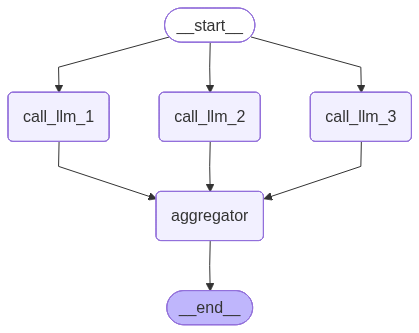

In [5]:
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Save the workflow as image
# parallel_workflow.get_graph().draw_mermaid_png(output_file_path="parallel_flow.png")

### Invoke

In [6]:
for node in parallel_workflow.stream({"topic": "cats"}):
    print(node)

{'call_llm_1': {'joke': 'Why did the cat join a band?\n\nBecause it wanted to be the purr-cussionist!'}}
{'call_llm_3': {'poem': "Whiskers twitch, ears perk up high,\nAs feline forms go gliding by,\nTheir fur a soft and silky stream,\nThat ripples in the sun's warm beam.\n\nWith eyes like jewels, bright and green,\nThey watch the world with secrets unseen,\nTheir little noses sniff the air,\nAs they prowl through their domain with care.\n\nTheir purrs a soothing, gentle sound,\nAs they curl up, snug and round,\nTheir tails a-twitch, a language all their own,\nAs they communicate, and make their throne.\n\nIn sunbeams, they find joy and delight,\nAnd chase the dust, with playful might,\nTheir little paws, a whispered hush,\nAs they stalk their prey, with stealthy rush.\n\nBut when the night, with darkness falls,\nThey become the hunters, with cunning calls,\nTheir eyes aglow, like lanterns bright,\nAs they prowl through the shadows, with silent flight.\n\nOh, cats, oh cats, with mystery